# Solution

### Dataset preparing

In [7]:
#!/usr/bin/env python3
# Download the 56 zip files in Images_png in batches
import urllib.request

# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    # 'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    # 'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	# 'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	# 'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    # 'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	# 'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	# 'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	# 'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	# 'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading'+fn+'...')
    urllib.request.urlretrieve(link, fn)  # download the zip file

print("Download complete. Please check the checksums")

downloadingimages_01.tar.gz...
downloadingimages_02.tar.gz...
downloadingimages_03.tar.gz...
Download complete. Please check the checksums


In [11]:
!mkdir /kaggle/working/images
!tar -xvzf /kaggle/working/images_01.tar.gz -C /kaggle/working/images
!tar -xvzf /kaggle/working/images_02.tar.gz -C /kaggle/working/images
!tar -xvzf /kaggle/working/images_03.tar.gz -C /kaggle/working/images

In [12]:
!rm -rf /kaggle/working/images_01.tar.gz
!rm -rf /kaggle/working/images_02.tar.gz
!rm -rf /kaggle/working/images_03.tar.gz

In [13]:
import os
import shutil 


for fn in os.listdir('/kaggle/input/true-labels'):
    fp = os.path.join('/kaggle/input/true-labels', fn)
    shutil.copy(fp, '/kaggle/working/images/')

We could not download all the batches because of Kaggle restrictions so we've downloaded the **first 3 batches only**.      
Now let's open some images to check what are we dealing with.

In [53]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import glob
import torch
import torchvision
import pandas as pd
import random
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import time
from collections import defaultdict
from pathlib import Path

Total sum of images:  24999


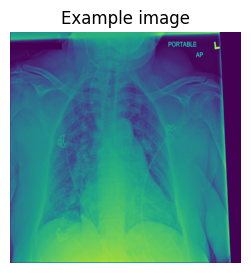

In [54]:
root = '/kaggle/working/images/images/'
print('Total sum of images: ', len(glob.glob(root + '*.png')))
fp_example = os.path.join(root, os.listdir(root)[0])

plt.figure(figsize=(5, 3))
plt.imshow(Image.open(fp_example))
plt.title('Example image')
plt.axis('off');

The column names are corrupted a little bit:

In [55]:
df = pd.read_csv('/kaggle/input/bbox-list-2017-csv/BBox_List_2017.csv')
df = df[['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]']]

In [56]:
df = df.rename(columns={
    "Image Index": "image_id", 
    "Finding Label": "labels",
    'Bbox [x': 'x',
    'h]': 'h'
})

In [57]:
df

,image_id,labels,x,y,w,h
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695
...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778


In [58]:
labels = list(df['labels'].unique())
labels

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltrate',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax']

### EDA

We have ready-made splitting [here](https://nihcc.app.box.com/v/ChestXray-NIHCC/file/256055473534) but since we work with 3 batches only then we need to build our own train-test splittng.

Let's make some tiny EDA.

Firstly we have to check classes distribution.

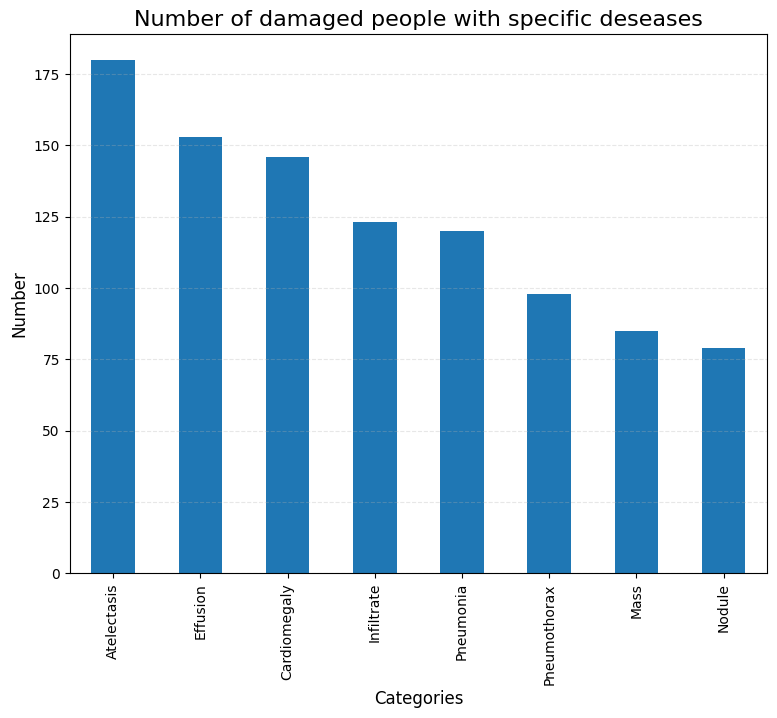

In [203]:
def plot_df_hist(df):
    value_counts = df['labels'].value_counts()
    plt.figure(figsize=(9, 7))
    value_counts.plot(kind='bar')
    plt.title('Number of damaged people with specific deseases', fontsize=16)
    plt.xlabel('Categories', fontsize=12)
    plt.ylabel('Number', fontsize=12)
    plt.grid(axis='y', alpha=0.3, linestyle='--')


plot_df_hist(df)

In [59]:
def split_data_file(df, ratio=0.8):
    train_num = int(ratio*len(df))
    train_idx = random.sample(range(len(df)), train_num)
    test_idx = set(range(len(df))).difference(train_idx)
    train_name = [df.iloc[i] for i in train_idx]
    test_name = [df.iloc[i] for i in test_idx]
    return train_name, test_name

In [60]:
import random


df_train, df_test = split_data_file(df)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [61]:
df_train.head()

,image_id,labels,x,y,w,h
520,00006304_060.png,Infiltrate,698.920635,334.831746,173.375661,254.645503
888,00025252_053.png,Pneumothorax,650.240000,639.753490,145.635556,262.826667
636,00014014_013.png,Mass,649.075132,383.593651,170.124868,170.124868
732,00009403_002.png,Nodule,645.824339,637.155556,72.601058,72.601058
209,00026889_000.png,Cardiomegaly,237.016949,371.796610,593.355932,453.423729


In [62]:
df_test.head()

,image_id,labels,x,y,w,h
7,00022098_006.png,Atelectasis,494.101695,577.392098,271.186441,154.033898
10,00030674_000.png,Atelectasis,632.949153,251.968369,227.796610,210.440678
11,00003945_004.png,Atelectasis,68.881356,471.087013,305.898305,168.135593
16,00007557_026.png,Atelectasis,131.796610,706.476844,221.288136,123.661017
21,00010770_000.png,Atelectasis,244.610169,371.290403,206.101695,68.338983


In [205]:
len(df_train), len(df_test)

(787, 197)

### Training

In [206]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [218]:
from torchvision.models.detection import (
    fasterrcnn_mobilenet_v3_large_fpn,
    FasterRCNN_MobileNet_V3_Large_FPN_Weights,
)

NUM_CLASSES = len(labels)+1  # healthy included


def get_faster_rcnn_model(num_classes):
    """return model and preprocessing transform"""
    model = fasterrcnn_mobilenet_v3_large_fpn(
        weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT
    )
    model.roi_heads.box_predictor.cls_score = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.cls_score.in_features,
        out_features=num_classes,
        bias=True,
    )
    model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(
        in_features=model.roi_heads.box_predictor.bbox_pred.in_features,
        out_features=num_classes * 4,
        bias=True,
    )
    preprocess = FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT.transforms()
    return model, preprocess


model, preprocess = get_faster_rcnn_model(num_classes=NUM_CLASSES)
model.to(device);

In [219]:
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, image_dir='.', transforms=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
        # Map class to index
        self.classes = sorted(dataframe['labels'].unique())
        self.class_to_idx = {cls: idx+1 for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx+1: cls for idx, cls in enumerate(self.classes)}
        
        # Filter existing images only
        self.valid_indices = []
        self.image_ids = []
        
        # Collect unique image_id
        unique_image_ids = dataframe['image_id'].unique()
        
        for img_id in unique_image_ids:
            img_path = os.path.join(self.image_dir, img_id)
            if os.path.exists(img_path):
                self.valid_indices.append(len(self.image_ids))
                self.image_ids.append(img_id)
            else:
                print(f"Warning: Image {img_id} not found at {img_path}. Skipping.")
        
        print(f"Found {len(self.image_ids)} valid images out of {len(unique_image_ids)}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        # Getting real indice after filtration
        real_idx = self.valid_indices[idx]
        image_id = self.image_ids[real_idx]
        
        try:
            img_path = os.path.join(self.image_dir, image_id)
            image = Image.open(img_path).convert("RGB")
            records = self.dataframe[self.dataframe['image_id'] == image_id]
            
            # If there are annotation for the image
            if len(records) == 0:
                print(f"Warning: No annotations found for image {image_id}")
                boxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros((0,), dtype=torch.int64)
                area = torch.zeros((0,), dtype=torch.float32)
            else:
                boxes = []
                labels = []
                
                for _, row in records.iterrows():
                    x_center, y_center, width, height = row['x'], row['y'], row['w'], row['h']
                    
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2
                
                if len(boxes) == 0:
                    boxes = torch.zeros((0, 4), dtype=torch.float32)
                    labels = torch.zeros((0,), dtype=torch.int64)
                    area = torch.zeros((0,), dtype=torch.float32)
                else:
                    boxes = torch.as_tensor(boxes, dtype=torch.float32)
                    labels = torch.as_tensor(labels, dtype=torch.int64)
                    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            
            image_id_tensor = torch.tensor([real_idx])
                        
            target = {
                "boxes": boxes,
                "labels": labels,
                "image_id": image_id_tensor,
                "area": area,
            }
            
            if self.transforms:
                try:
                    image = self.transforms(image)
                except Exception as e:
                    print(f"Error applying transforms to image {image_id}: {e}")
                    # Возвращаем пустое изображение и цели
                    return self._get_empty_sample()
            
            return image, target
            
        except Exception as e:
            print(f"Error loading image {image_id}: {e}")
            return self._get_empty_sample()
    
    def _get_empty_sample(self):
        empty_image = Image.new('RGB', (224, 224), color='black')
        
        if self.transforms:
            empty_image = self.transforms(empty_image)
        
        empty_target = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
            "image_id": torch.tensor([-1]),
            "area": torch.zeros((0,), dtype=torch.float32),
            "iscrowd": torch.zeros((0,), dtype=torch.int64)
        }
        
        return empty_image, empty_target

In [220]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
])

In [162]:
train_dataset = ChestXRayDataset(df_train, image_dir='/kaggle/working/images', transforms=transform)
test_dataset = ChestXRayDataset(df_test, image_dir='/kaggle/working/images', transforms=transform)

Found 605 valid images out of 714
Found 171 valid images out of 194


In [163]:
def collate_fn(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    
    if len(batch) == 0:
        return [], []
    
    images, targets = zip(*batch)
    
    filtered_data = []
    for img, tgt in zip(images, targets):
        if tgt['image_id'].item() != -1:
            filtered_data.append((img, tgt))
    
    if len(filtered_data) == 0:
        return [], []
    
    images, targets = zip(*filtered_data)
    return images, targets

In [164]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    
    total_loss = 0
    total_loss_dict = {}
    batch_count = 0
    
    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (images, targets) in enumerate(progress_bar):
        if len(images) == 0:
            continue
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        if len(targets) == 0 or all(len(t['boxes']) == 0 for t in targets):
            continue
        
        try:
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            total_loss += losses.item()
            batch_count += 1
            
            for key in loss_dict:
                if key not in total_loss_dict:
                    total_loss_dict[key] = 0
                total_loss_dict[key] += loss_dict[key].item()
            
            if batch_count % 10 == 0:
                progress_bar.set_postfix({
                    'loss': losses.item(),
                    'avg_loss': total_loss / batch_count if batch_count > 0 else 0
                })
                
        except Exception as e:
            print(f"Error in training batch {batch_idx}: {e}")
            continue
    
    if batch_count > 0:
        avg_loss = total_loss / batch_count
        print(f"\nEpoch {epoch} average loss: {avg_loss:.4f}")
        
        for key in total_loss_dict:
            avg_key_loss = total_loss_dict[key] / batch_count
            print(f"  {key}: {avg_key_loss:.4f}")
        
        return avg_loss
    else:
        print(f"\nEpoch {epoch}: No valid batches to train on")
        return 0.0

In [180]:
BATCH_SIZE = 4
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn,
)

valid_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn,
)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.0001)

num_epochs = 40

train_loss_list = []
validation_loss_list = []
model.train()
for epoch in range(num_epochs):
    N = len(train_loader.dataset)
    current_train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [
            {
                k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()
            }
            for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        current_train_loss += losses
    train_loss_list.append(current_train_loss / N)

    N = len(validation_loader.dataset)
    current_validation_loss = 0
    with torch.no_grad():
        for images, targets in validation_loader:
            images = list(image.to(device) for image in images)
            targets = [
                {
                    k: v.to(device) if isinstance(v, torch.Tensor) else v
                    for k, v in t.items()
                }
                for t in targets
            ]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            current_validation_loss += losses
    validation_loss_list.append(current_validation_loss / N)

    print(f"epoch: {epoch}")
    print(
        f"train loss: {train_loss_list[-1]}, validation loss: {validation_loss_list[-1]}"
    )

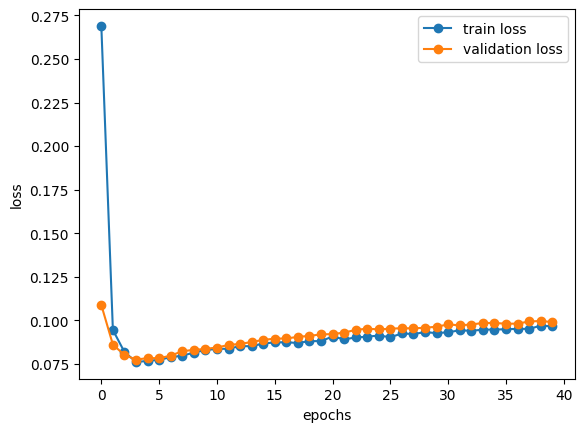

In [111]:
torch.save(model, "./model.pth")

# plot losses
train_loss = [x.cpu().detach().numpy() for x in train_loss_list]
validation_loss = [x.cpu().detach().numpy() for x in validation_loss_list]

plt.plot(train_loss, "-o", label="train loss")
plt.plot(validation_loss, "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

In [167]:
model = torch.load("./model.pth", weights_only=False)

In [174]:
img, _ = test_dataset[random.randint(0, len(test_dataset) - 1)]

In [175]:
import torchvision.transforms as T
import random
from IPython.display import display  # to display images
from PIL import ImageDraw


def inference(img, device, model):
    model.eval()
    with torch.no_grad():
        pred = model([img.to(device)])

    # display image with bbox
    transform = T.ToPILImage()
    img = transform(img)
    print(pred)
    x1, y1, x2, y2 = pred[0]["boxes"].cpu().detach().numpy()[0]
    # draw = ImageDraw.Draw(img)
    # draw.rectangle([x1, y1, x2, y2], fill=None, outline="#ff0000cc", width=2)
    return pred


inference(img, device, model)

[{'boxes': tensor([[ 22.3604, 120.0431, 739.6719, 583.2766],
        [  0.0000, 277.1856, 560.8262, 541.1380],
        [ 18.4784, 366.3785, 545.9920, 617.1544],
        [406.5033, 101.4077, 591.0344, 319.7615],
        [337.0199,  42.3263, 610.7449, 617.0757],
        [ 33.6969, 254.4149, 649.1670, 705.4370]], device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2], device='cuda:0'), 'scores': tensor([0.0898, 0.0740, 0.0628, 0.0544, 0.0518, 0.0504], device='cuda:0')}]


[{'boxes': tensor([[ 22.3604, 120.0431, 739.6719, 583.2766],
          [  0.0000, 277.1856, 560.8262, 541.1380],
          [ 18.4784, 366.3785, 545.9920, 617.1544],
          [406.5033, 101.4077, 591.0344, 319.7615],
          [337.0199,  42.3263, 610.7449, 617.0757],
          [ 33.6969, 254.4149, 649.1670, 705.4370]], device='cuda:0'),
  'labels': tensor([2, 2, 2, 2, 2, 2], device='cuda:0'),
  'scores': tensor([0.0898, 0.0740, 0.0628, 0.0544, 0.0518, 0.0504], device='cuda:0')}]

In [1]:
def draw_and_save_bbox(image, bboxes, output_path, color="red", thickness=3):
    
    transform = T.ToPILImage()
    image = transform(image)
    
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        draw.rectangle(bbox, outline=color, width=thickness)
    
    image.save(output_path)
    print(f"Saved: {output_path}")


draw_and_save_bbox(img, [[ 22.3604, 120.0431, 739.6719, 583.2766],
                         [  0.0000, 277.1856, 560.8262, 541.1380],
                         [ 18.4784, 366.3785, 545.9920, 617.1544],
                         [406.5033, 101.4077, 591.0344, 319.7615],
                         [337.0199,  42.3263, 610.7449, 617.0757],
                         [ 33.6969, 254.4149, 649.1670, 705.4370]], './ex_img.png')

Saved: ./ex_img.png
